# generate -> properties -> echem
- Generate microstructure from GAN
- calculate properties of electrolyte, particle, CBD phases
- simulate echem performance and extract metrics

c:\Users\pgasper\AppData\Local\anaconda3\envs\ustruct-to-echem\lib\site-packages\taufactor\taufactor.py:39: UserWarning: CUDA not available, defaulting device to cpu. To avoid this warning, explicitly set the device when initialising the solver with device=torch.device('cpu')
  warnings.warn(
At t = 461.77 and h = 3.92979e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 170.861 and h = 1.14391e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 469.624 and h = 1.62263e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 178.715 and h = 1.08257e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 569.306 and h = 2.69226e-17, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 278.397 and h = 3.74037e-21, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.942 and h = 4.31603e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 

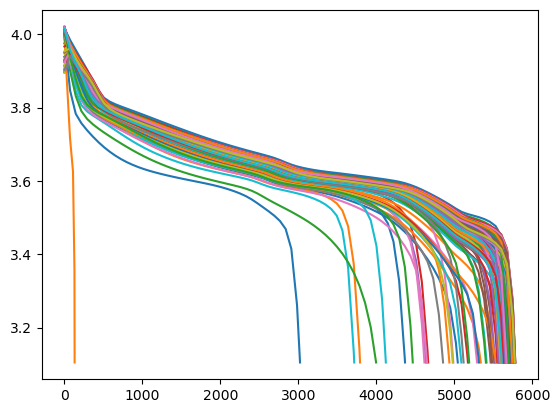

In [1]:
import numpy as np
import pybamm
import matplotlib.pyplot as plt
from utils.generate_new_volume import generate_new_volume
from utils.physical_properties import *

model_path = 'slicegan_model/four_phase_nmc'
phases = ['Pore','Crack','Particle','CBD']

# Diffusivity function to modify for Pybamm
def lico2_diffusivity(sto, T, coeff):
    """
    LiCo2 diffusivity as a function of stochiometry, in this case the
    diffusivity is taken to be a constant. The value is taken from Dualfoil [1].

    References
    ----------
    .. [1] http://www.cchem.berkeley.edu/jsngrp/fortran.html

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry
    T: :class:`pybamm.Symbol`
        Dimensional temperature

    Returns
    -------
    :class:`pybamm.Symbol`
        Solid diffusivity
    """
    #D_ref = 1 * 10 ** (-13)
    D_ref = (coeff / 0.4) * 10 ** (-13) # 0.4 is a random number picked from some GAN runs
    E_D_s = 18550
    arrhenius = pybamm.exp(E_D_s / pybamm.pybamm.constants.R * (1 / 298.15 - 1 / T))

    return D_ref * arrhenius

capacities = np.zeros((100,1))
for i in range(len(capacities)):
    vol = generate_new_volume(model_path)
    '''
    Properties to modify:
    - Positive electrode porosity
    - Positive electrode active material volume fraction
    Things to work on later:
    - inputting Deff into positive electrode diffusivity (need to modify function in parameters)
    - inputting particle size (current volume is too small to have 'particles')
        - use surface area to reverse calculate particle size? particle size controls surface area in pybamm (sphere = 3/(r*(1-vf_pore)))
    '''
    # Set all cracks and pores equal for porosity
    vol[vol==1] = 0
    vf_particle = volume_fraction(vol, phase_class=2)
    vf_pore     = volume_fraction(vol, phase_class=0)
    # pybamm can fail at extreme values
    if vf_particle > 0.85:
        vf_particle = 0.85
    if vf_pore < 0.09:
        vf_pore = 0.09

    # Diffusivity and tortuosity
    # Set all phases to 0 except particle for taufactor
    vol[vol==3] = 0
    vol[vol==2] = 1
    homogenized_properties = compute_tau_and_D_eff(vol, verbose=False)
    D_eff = homogenized_properties['D_eff'].item()

    ####print(i, vf_particle, vf_pore, D_eff)

    # PyBaMM model
    model = pybamm.lithium_ion.DFN()
    # Default parameter set
    params = pybamm.ParameterValues("Marquis2019")
    # Modify parameters
    params['Positive electrode porosity'] = vf_pore
    params['Positive electrode active material volume fraction'] = vf_particle
    params['Positive electrode diffusivity [m2.s-1]'] = lambda sto, T: lico2_diffusivity(sto, T, D_eff)
    # Run the simulation
    sim = pybamm.Simulation(model,parameter_values=params)
    sim.solve([0, 7200],initial_soc=1)
    sol = sim.solution
    # Save the discharge capacity
    capacities[i] = sol['Discharge capacity [A.h]'].entries[-1]

    # Plot to see if the simulations are any different
    plt.plot(sol['Time [s]'].entries, sol['Voltage [V]'].entries)

plt.show()


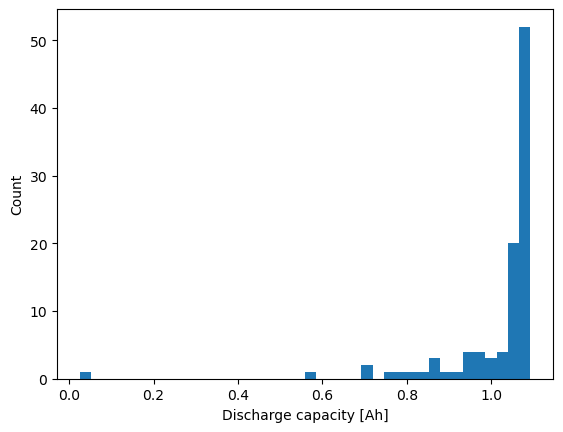

In [7]:
plt.hist(capacities, bins=40)
plt.xlabel('Discharge capacity [Ah]')
plt.ylabel('Count')
plt.show()

At t = 442.469, , mxstep steps taken before reaching tout.


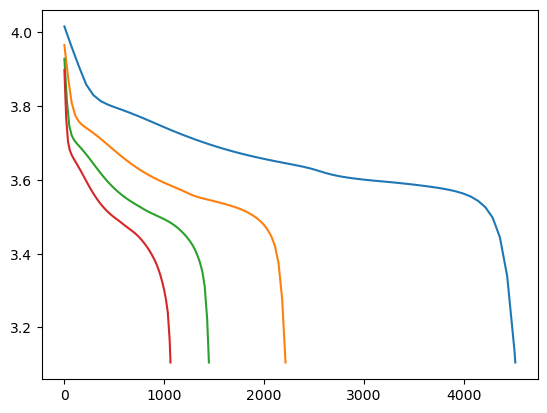

In [3]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

model = pybamm.lithium_ion.DFN()
# Default parameter set
params = pybamm.ParameterValues("Marquis2019")
# Modify parameters
current = params['Current function [A]']
for i in np.arange(4):
    params['Current function [A]'] = (i+1) * current
    sim = pybamm.Simulation(model,parameter_values=params)
    sim.solve([0, 7200/(i+1)],initial_soc=1)
    sol = sim.solution
    plt.plot(sol['Time [s]'].entries, sol['Voltage [V]'].entries)
